# **Jet parameter correlation and redundancy analysis**

This script handles the **loading, preprocessing, and analysis of jet event data** from JSON files. It extracts both **jet-level** and **constituent-level features** (such as $p_T$, $\eta$, $\phi$, mass, energy, and impact parameters), flattens them into Pandas DataFrames, and performs exploratory data analysis including scatter plots, histograms, and correlation studies. The script also compares kinematic distributions across different datasets and physics processes (QCD, H→bb, t→bqq, W→qq) and between simulated and real CMS data, providing visualizations of jet substructure variables and overall distributions for detailed understanding of jet properties and constituent behavior.


In [ ]:
import ijson
import numpy as np
import json
from decimal import Decimal
import json
import time
import torch
import warnings
import numpy as np
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats


## Section : Loading and Processing Jet Data

This section of the code handles the **loading and preprocessing of jet event data** from a JSON file. It performs the following steps:

1. **Data Loading:**  
   The function `cargar_datos_json` reads jet events from a specified JSON file. The user can select the number of jets (`num_jets`) and the number of constituents per jet (`num_constituents`) to process.

2. **Jet Kinematics Calculation:**  
   For each jet, the function extracts the transverse momentum (`pT`), pseudorapidity (`eta`), azimuthal angle (`phi`), and mass. It computes the total energy of the jet using the momentum components and mass.

3. **Constituent Selection:**  
   The jet’s particle flow candidates (constituents) are analyzed to calculate their transverse momentum. The function selects the top constituents based on the highest `pT` values.

4. **Constituent Feature Computation:**  
   For each of the top constituents, the function calculates derived quantities such as pseudorapidity (`eta`), azimuthal angle (`phi`), mass, energy, and impact parameters (`d0` and `dz`). This ensures the data is in a suitable format for subsequent quantum circuit encoding or analysis.

5. **Data Structuring:**  
   The processed jets and their top constituents are stored as dictionaries, allowing easy access to both jet-level and constituent-level features for later analysis or input to quantum models.

Finally, the processed data is returned as a list of events, each containing the jet kinematics and its top constituents.


### **Real CMS data**

In [ ]:
datos = []

def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']
        theta = 2 * np.arctan(np.exp(-jet_eta))
        p = jet_pt / np.sin(theta)
        pz  = p * np.cos(theta)
        jet_energy = np.sqrt(pz**2 + jet_pt**2 + jet_mass**2)
        # Calculate pT for each constituent
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Indices of the top 10 with highest pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convert each one to the format used in the circuit
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            d0 = cand[4]  # traversal impact parameter
            dz = cand[5]  # longitudinal impact parameter
            pt = np.sqrt(px**2 + py**2)
            p_total = np.sqrt(px**2 + py**2 + pz**2)
            eta = 0.5 * np.log((p_total + pz) / (p_total - pz + 1e-8))  # avoid division by 0
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))#In case of negative mass, set to zero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass,
                'energy': E,
                'd0': d0,
                'dz': dz
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'constituents': top_constituents
        })

    return eventos

datos = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_reducido_22500.json')

### **Simulated CMS data**

In [ ]:

def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract jet kinematics
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        jet_energy = evento.get('jet_energy', i)
        jet_tau1 = evento.get('jet_tau1', i)
        jet_tau2 = evento.get('jet_tau2', i)
        jet_tau3 = evento.get('jet_tau3', i)    
        jet_tau4 = evento.get('jet_tau4', i)

        jet_tau12 = jet_tau1 / jet_tau2 if jet_tau2 != 0 else 0
        jet_tau23 = jet_tau2 / jet_tau3 if jet_tau3 != 0 else 0
        jet_tau34 = jet_tau3 / jet_tau4 if jet_tau4 != 0 else 0

        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        part_d0val = np.array(evento.get('part_d0val', []))
        part_dzval = np.array(evento.get('part_dzval', []))
        
        # Calculate pT, eta, phi, mass for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        eta = 0.5 * np.log((p_total + part_pz) / (p_total - part_pz + 1e-8))  # Avoiding dividing by 0
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Select the num_constituents with the highest pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx],
                'energy': part_energy[idx],
                'd0': part_d0val[idx],
                'dz': part_dzval[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'tau1_jet': jet_tau1,
            'tau2_jet': jet_tau2,
            'tau3_jet': jet_tau3,
            'tau4_jet': jet_tau4,
            'tau12_jet': jet_tau12,
            'tau23_jet': jet_tau23,
            'tau34_jet': jet_tau34,
            'constituents': top_constituents
        })

    return eventos

datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120_flat.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120_flat.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120_flat.json', num_jets=10000, num_constituents=10)
datos_QCD_simu_1 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_2 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_full = datos_QCD_simu_1 + datos_QCD_simu_2

### **Convert data to panda dataframe**

In [ ]:
df1 = pd.DataFrame(datos)

,pt_jet,eta_jet,phi_jet,mass_jet,energy_jet,constituents
0,408.75,0.950439,2.559570,10.914062,607.790163,"[{'pt': 140.2500004129156, 'eta': 0.9534912076..."
1,353.25,-0.899414,-0.696411,104.875000,516.778920,"[{'pt': 67.50000190873924, 'eta': -0.766845667..."
2,385.50,2.114258,0.822266,4.828125,1619.908742,"[{'pt': 112.43750079899348, 'eta': 2.096679660..."
3,371.25,2.100586,-2.334473,25.359375,1539.660259,"[{'pt': 69.62500171304517, 'eta': 2.0537109113..."
4,426.75,0.202057,1.660400,5.500000,435.525866,"[{'pt': 152.7500023117988, 'eta': 0.2078247094..."
...,...,...,...,...,...,...
22495,462.75,-1.389648,-0.667358,33.843750,986.839980,"[{'pt': 78.81249867197027, 'eta': -1.366455113..."
22496,343.75,0.615356,-2.423828,9.367188,411.019357,"[{'pt': 109.7500000954542, 'eta': 0.6206054796..."
22497,458.25,1.955811,-1.871338,84.312500,1654.392343,"[{'pt': 97.06249850935771, 'eta': 1.9304199598..."
22498,317.00,-0.441284,0.873169,71.000000,355.530638,"[{'pt': 55.65624911915513, 'eta': -0.303588866..."


## **Extracting constituent features for analysis**

This code iterates through the processed jet dataset and collects the **kinematic and impact parameter features** of each constituent particle ($p_T$, $\eta$, $\phi$, $m$, $E$, $d_0$, $d_z$) into a dictionary. The collected data is then converted into a **Pandas DataFrame**, enabling easy statistical analysis, visualization, and correlation studies between different jet parameters.


In [34]:
dataGraph = {'pt': [], 'eta': [], 'phi': [], 'mass': [], 'energy': [], 'd0': [], 'dz': []}

for i in range(len(datos)):
    num_jets = len(datos[i]['constituents'])
    for j in range(num_jets):
        dataGraph['pt'].append(datos[i]['constituents'][j]['pt'])
        dataGraph['eta'].append(datos[i]['constituents'][j]['eta'])
        dataGraph['phi'].append(datos[i]['constituents'][j]['phi'])
        dataGraph['mass'].append(datos[i]['constituents'][j]['mass'])
        dataGraph['energy'].append(datos[i]['constituents'][j]['energy'])
        dataGraph['d0'].append(datos[i]['constituents'][j]['d0'])
        dataGraph['dz'].append(datos[i]['constituents'][j]['dz'])


df2 = pd.DataFrame(dataGraph)
df2

,pt,eta,phi,mass,energy,d0,dz
0,140.250000,0.953491,2.535645,0.000000,208.982727,-1.000000,-1.000000
1,41.437498,0.955689,2.609863,0.000000,61.845627,-1.000000,-1.000000
2,26.312500,0.944702,2.564453,0.139704,38.953835,-0.000012,0.001708
3,21.484375,0.971558,2.568359,0.139125,32.447609,0.001632,0.001673
4,19.781251,0.954224,2.563965,0.139367,29.491848,-0.014641,0.004684
...,...,...,...,...,...,...,...
224916,5.925781,0.662354,-1.228516,0.139521,7.275198,-0.000434,0.003897
224917,5.390625,0.979492,-1.888916,0.139544,8.191179,-0.003277,0.003447
224918,4.421875,0.355408,-1.500000,0.139528,4.706170,-0.008034,0.003706
224919,4.335937,0.863037,-1.968750,0.139533,6.055070,0.006317,0.003933


## Flattening jet constituent features

This code extracts the kinematic and impact parameter features ($p_T$, $\eta$, $\phi$, $m$, $E$, $d_0$, $d_z$) from each constituent across all jets and stores them into separate lists. This flattened structure simplifies subsequent analysis and allows easy computation of statistics or correlations for individual features.


In [10]:
datos
pt = []
eta = []
phi = []
mass = []
energy = []
d0 = []
dz = []

for i in range(len(datos)):
    num_jets = len(datos[i]['constituents'])
    for j in range(num_jets):
        pt.append(datos[i]['constituents'][j]['pt'])
        eta.append(datos[i]['constituents'][j]['eta'])
        phi.append(datos[i]['constituents'][j]['phi'])
        mass.append(datos[i]['constituents'][j]['mass'])
        energy.append(datos[i]['constituents'][j]['energy'])
        d0.append(datos[i]['constituents'][j]['d0'])
        dz.append(datos[i]['constituents'][j]['dz'])    

## Scatter Plot of η vs pT

This code generates a scatter plot showing the relationship between the pseudorapidity (η) and transverse momentum ($p_T$) of all jet constituents. It provides a visual overview of how these two key kinematic variables are distributed and correlated across the dataset.

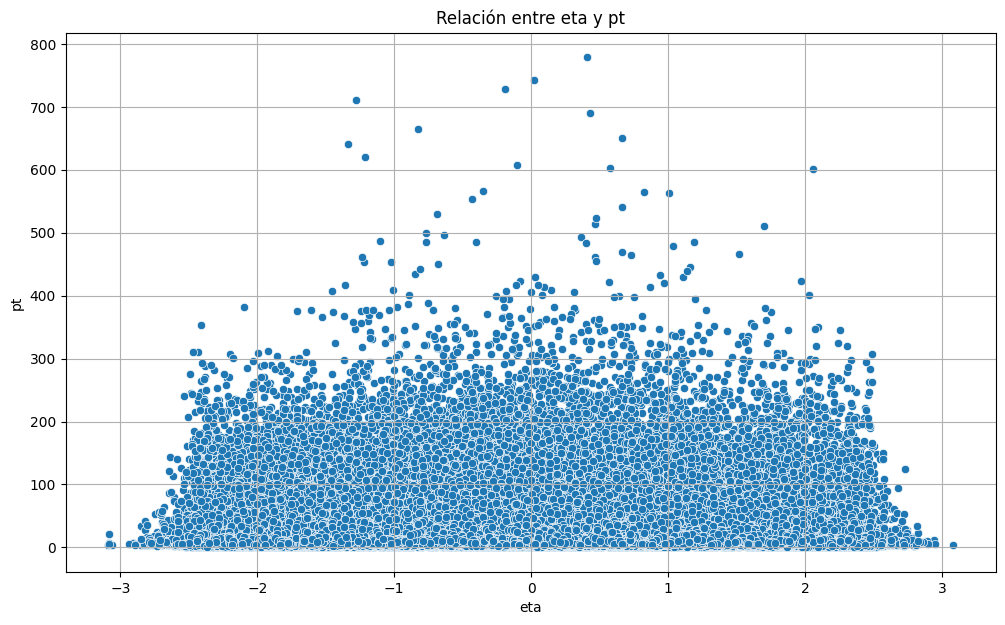

In [12]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='eta', y='pt', data=df2)
plt.xlabel('eta')
plt.ylabel('pt')
plt.title('Relación entre eta y pt')
plt.grid(True)
plt.show()

## Scatter Plot of φ vs pT

This code generates a scatter plot showing the relationship between the azimuthal angle (φ) and transverse momentum (pT) of all jet constituents. It helps visualize the distribution and correlation of these two kinematic variables across the dataset.


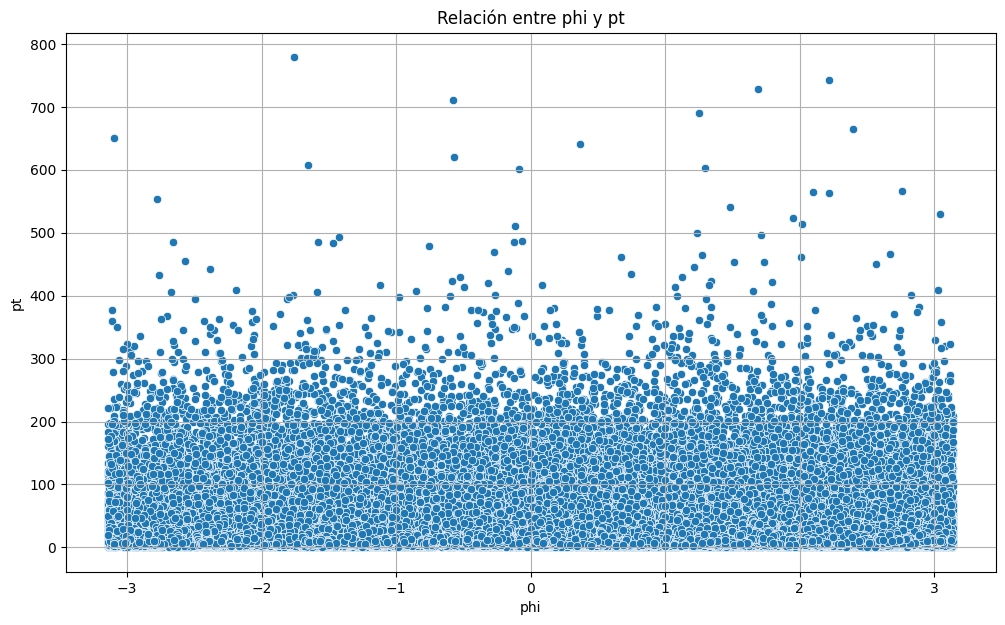

In [14]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='phi', y='pt', data=df2)
plt.xlabel('phi')
plt.ylabel('pt')
plt.title('Relación entre phi y pt')
plt.grid(True)
plt.show()

## Scatter Plot of Mass vs pT

This code generates a scatter plot displaying the relationship between the mass and transverse momentum (pT) of jet constituents. It allows us to examine how constituent mass correlates with its momentum across the dataset.


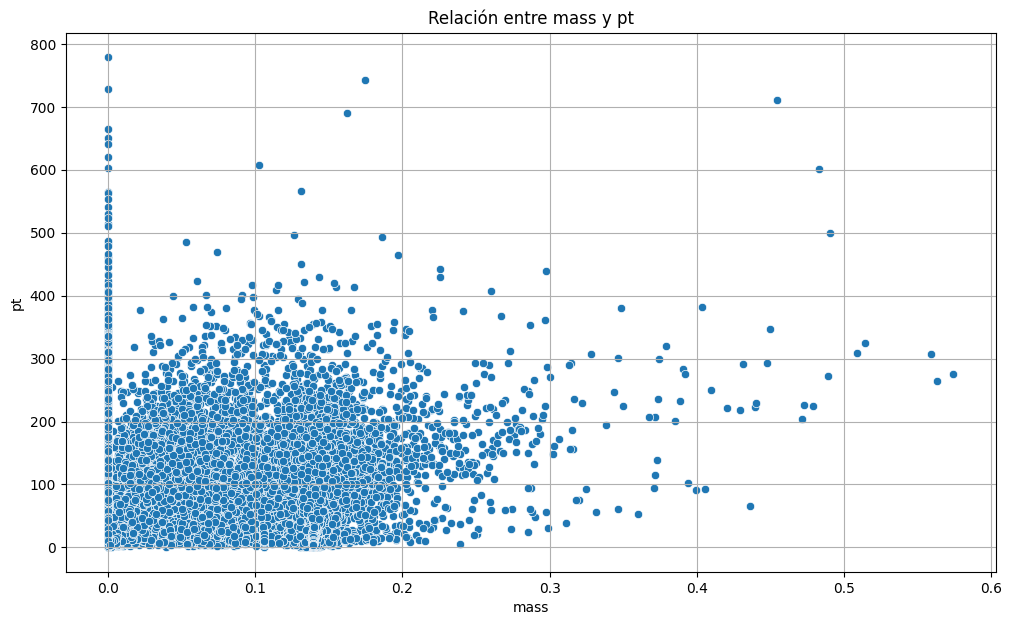

In [15]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='mass', y='pt', data=df2)
plt.xlabel('mass')
plt.ylabel('pt')
plt.title('Relación entre mass y pt')
plt.grid(True)
plt.show()

## Scatter Plot of Energy vs pT

This code creates a scatter plot to visualize the relationship between the energy and transverse momentum (pT) of jet constituents, helping to identify patterns or correlations in the dataset.


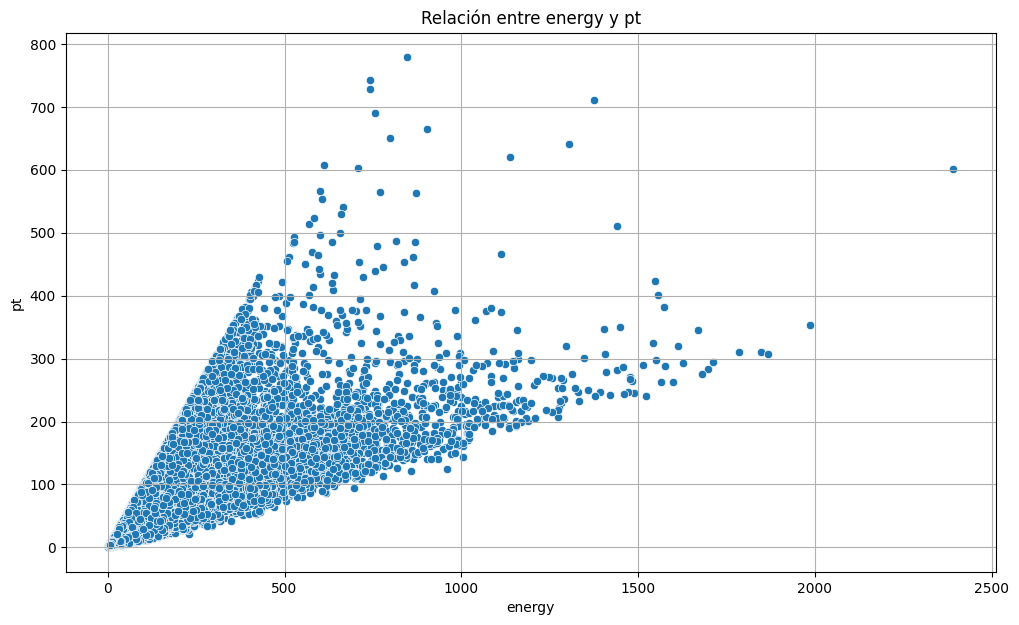

In [16]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='energy', y='pt', data=df2)
plt.xlabel('energy')
plt.ylabel('pt')
plt.title('Relación entre energy y pt')
plt.grid(True)
plt.show()

## Scatter Plot of Eta vs Phi

This code generates a scatter plot showing the correlation between the pseudorapidity (eta) and azimuthal angle (phi) of jet constituents, providing insight into their spatial distribution within the detector.


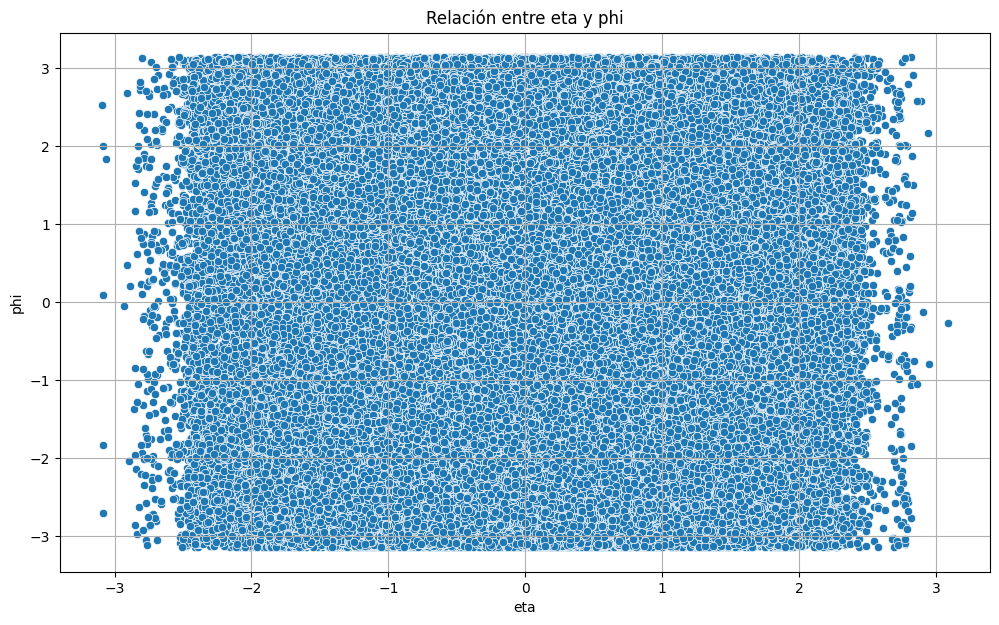

In [17]:
plt.figure(figsize=(12,7))
sns.scatterplot(x='eta', y='phi', data=df2)
plt.xlabel('eta')
plt.ylabel('phi')
plt.title('Relación entre eta y phi')
plt.grid(True)
plt.show()

### **More plots...**

<Axes: xlabel='pt', ylabel='eta'>

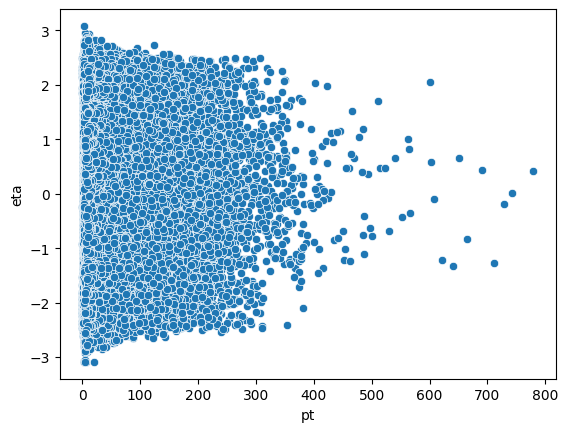

In [18]:
sns.scatterplot(x="pt", y="eta", data=df2)

<Axes: xlabel='pt', ylabel='phi'>

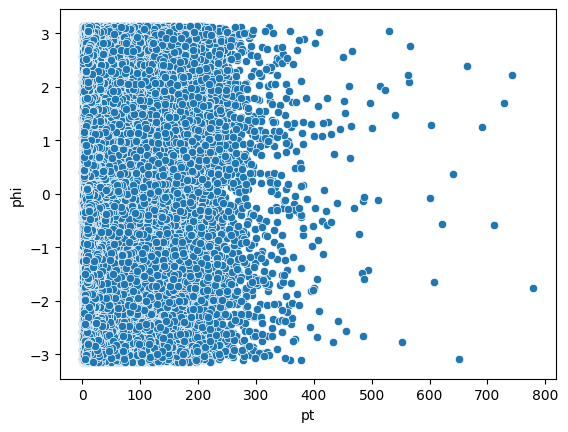

In [19]:
sns.scatterplot(x="pt", y="phi", data=df2)

<Axes: xlabel='pt', ylabel='mass'>

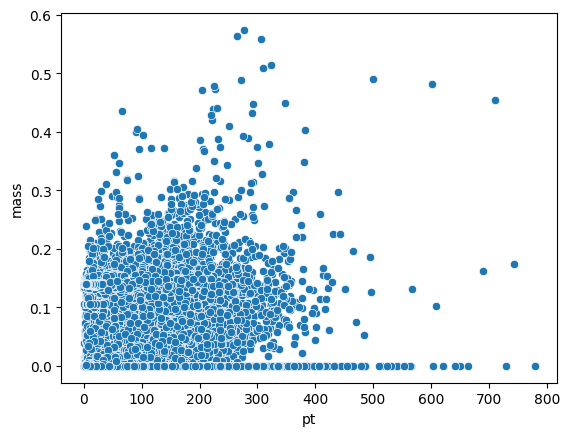

In [20]:
sns.scatterplot(x="pt", y="mass", data=df2)

## Correlation analysis

This code computes the **Pearson correlation coefficient** between the transverse momentum (`pt`) and pseudorapidity (`eta`) of jet constituents. It also calculates the full **correlation matrix** for all kinematic and geometric variables, rounds the values for readability, and visualizes the correlations using a **heatmap** to identify potential relationships and redundancies among the features.


A value of r = 0 indicates no correlation (the variables are independent) and r = -1 indicates the variables are inversely correlated (an increase in one variable is associated with a decrease in the other). The Person Result first value correspond to r

In [ ]:

stats.pearsonr(df2['pt'], df2['eta'])
cormat = df2.corr()
round(cormat,2)

,pt,eta,phi,mass,energy,d0,dz
pt,1.00,-0.00,0.00,-0.09,0.80,-0.10,-0.16
eta,-0.00,1.00,-0.01,-0.00,-0.00,-0.00,-0.00
phi,0.00,-0.01,1.00,-0.01,0.00,-0.00,-0.00
mass,-0.09,-0.00,-0.01,1.00,-0.05,0.63,0.96
energy,0.80,-0.00,0.00,-0.05,1.00,-0.08,-0.13
d0,-0.10,-0.00,-0.00,0.63,-0.08,1.00,0.65
dz,-0.16,-0.00,-0.00,0.96,-0.13,0.65,1.00


<Axes: >

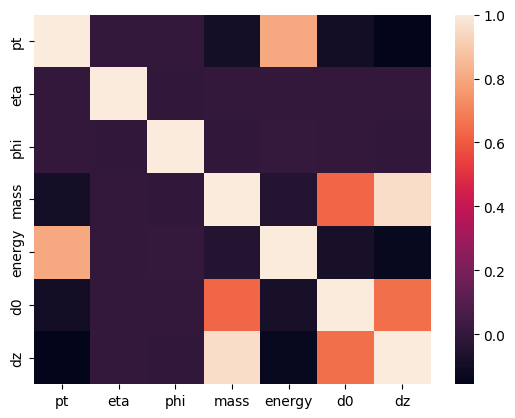

In [23]:
sns.heatmap(cormat)

## Constructing a flattened dataFrame for jet constituents

This code iterates over each jet in the dataset and its corresponding constituents, collecting both **jet-level** (`pt`, `eta`, `phi`, `mass`, `energy`) and **constituent-level** (`pt`, `eta`, `phi`, `mass`, `energy`, `d0`, `dz`) information. Each constituent is also assigned an **index** within the jet. All the data is aggregated into a **flattened Pandas DataFrame** (`df`) for easier analysis and visualization of jet and constituent properties.


In [37]:
rows = []

for evento in datos:
    pt_jet = evento['pt_jet']
    eta_jet = evento['eta_jet']
    phi_jet = evento['phi_jet']
    mass_jet = evento['mass_jet']
    energy_jet = evento['energy_jet']
    
    for i, cand in enumerate(evento['constituents']):
        rows.append({
            'jet_pt': pt_jet,
            'jet_eta': eta_jet,
            'jet_phi': phi_jet,
            'jet_mass': mass_jet,
            'jet_energy': energy_jet,
            'cand_pt': cand['pt'],
            'cand_eta': cand['eta'],
            'cand_phi': cand['phi'],
            'cand_mass': cand['mass'],
            'cand_energy': cand['energy'],
            'cand_d0': cand['d0'],
            'cand_dz': cand['dz'],
            'cand_idx': i+1  # índice del constituyente (1-10)
        })

df = pd.DataFrame(rows)


kde=True is a Seaborn parameter (also in sns.histplot) that stands for:

**Kernel Density Estimate**

In a normal histogram, we see bars that count how many values fall into each range.

With **kde=True**, in addition to the bars, Seaborn draws a smooth curve that estimates the continuous density of the data, like a smoothed version of the histogram.

### **Plots** 

This code generates a histogram of the constituent masses from the flattened DataFrame `df`. It includes a **kernel density estimate (KDE)** to visualize the mass distribution, labels the axes, and adds a legend for clarity. The plot helps understand the nominal mass distribution of jet constituents.

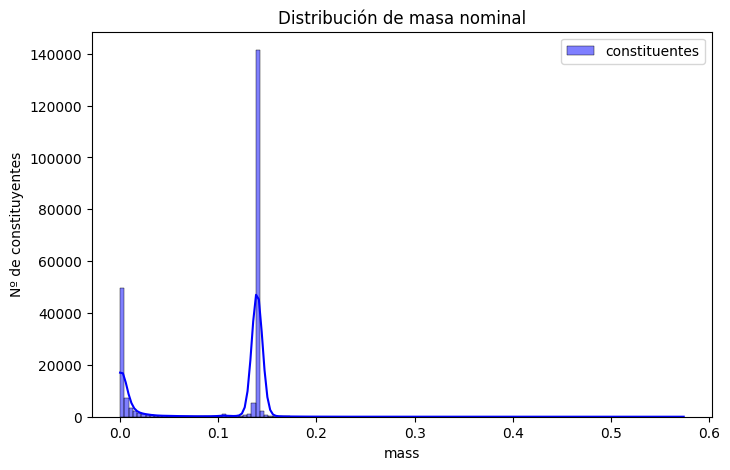

In [28]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_mass'], color='blue', label='constituentes', kde=True)
plt.xlabel('mass')
plt.ylabel('Nº de constituyentes')
plt.legend()
plt.title('Distribución de masa nominal')
plt.show()

This code creates a histogram of the constituent masses from the DataFrame `df`. It labels the x-axis as mass, includes a legend, and visualizes the nominal mass distribution of the jet constituents without a kernel density estimate.


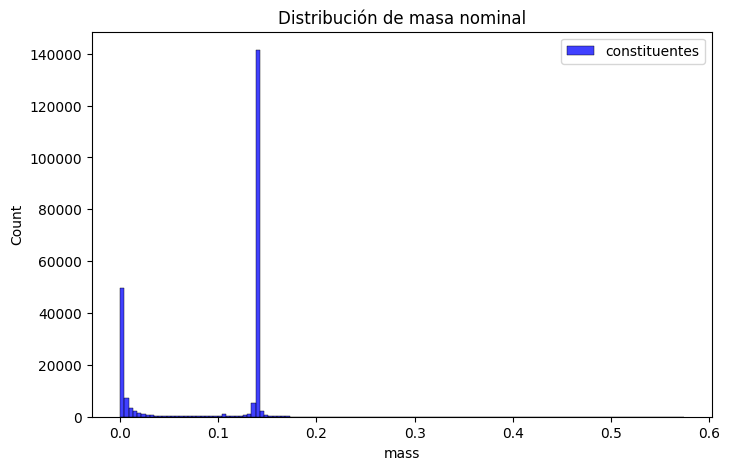

In [27]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_mass'], color='blue', label='constituentes')
plt.xlabel('mass')
plt.legend()
plt.title('Distribución de masa nominal')
plt.show()

This code generates a histogram of the constituent energies from the DataFrame `df`. The x-axis is labeled as energy, a legend is included, and it visualizes the energy distribution of the jet constituents.

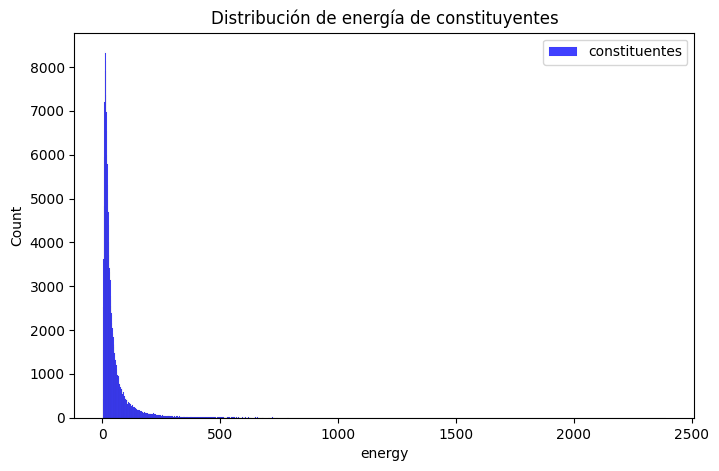

In [29]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_energy'], color='blue', label='constituentes')
plt.xlabel('energy')
plt.legend()
plt.title('Distribución de energía de constituyentes')
plt.show()

This code plots a histogram comparing the transverse momentum (`pt`) distributions of jets and their constituents. Constituent `pt` values are shown in blue, jet `pt` values in red, both with kernel density estimates (KDE) for smooth distribution visualization. The x-axis is labeled `pt`, and a legend distinguishes constituents from jets.


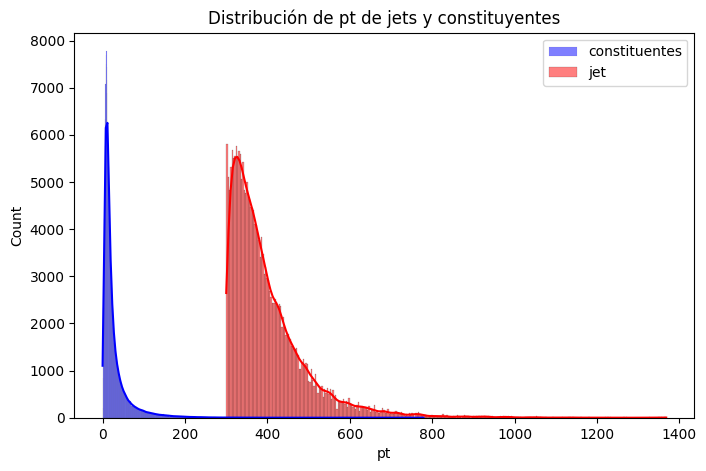

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_pt'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_pt'], color='red', label='jet', kde=True)
plt.xlabel('pt')
plt.legend()
plt.title('Distribución de pt de jets y constituyentes')
plt.show()

This code plots a histogram comparing the pseudorapidity (`eta`) distributions of jets and their constituents. Constituent `eta` values are shown in blue, jet `eta` values in red, both with kernel density estimates (KDE) for smooth distribution visualization. The x-axis is labeled `eta`, and a legend distinguishes constituents from jets.


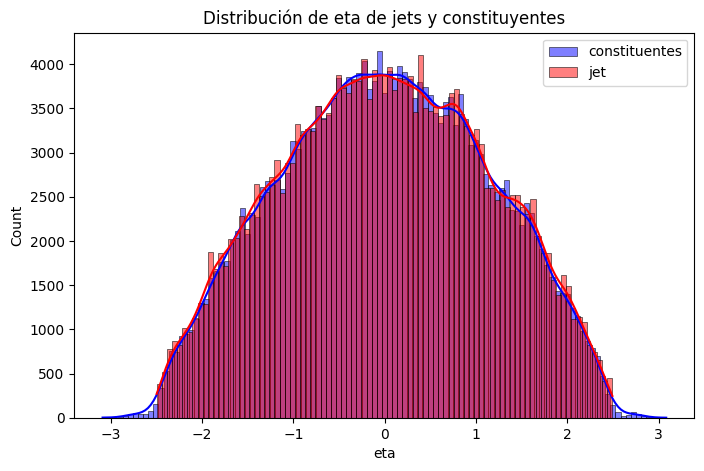

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_eta'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_eta'], color='red', label='jet', kde=True)
plt.xlabel('eta')
plt.legend()
plt.title('Distribución de eta de jets y constituyentes')
plt.show()

This code generates a histogram comparing the azimuthal angle (`phi`) distributions of jets and their constituents. Constituent `phi` values are displayed in blue, jet `phi` values in red, both with kernel density estimates (KDE) to visualize the distribution smoothly. The x-axis is labeled `phi`, and the legend differentiates constituents from jets.


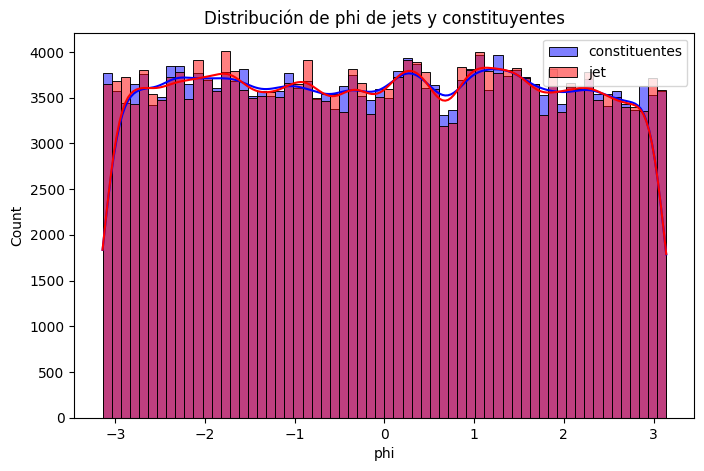

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_phi'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_phi'], color='red', label='jet', kde=True)
plt.xlabel('phi')
plt.legend()
plt.title('Distribución de phi de jets y constituyentes')
plt.show()

This code plots a histogram comparing the mass distributions of jets and their constituents. Constituent masses are shown in blue, jet masses in red, both with kernel density estimates (KDE) to smooth the distributions. The x-axis is labeled `mass`, and the legend differentiates between constituents and jets.


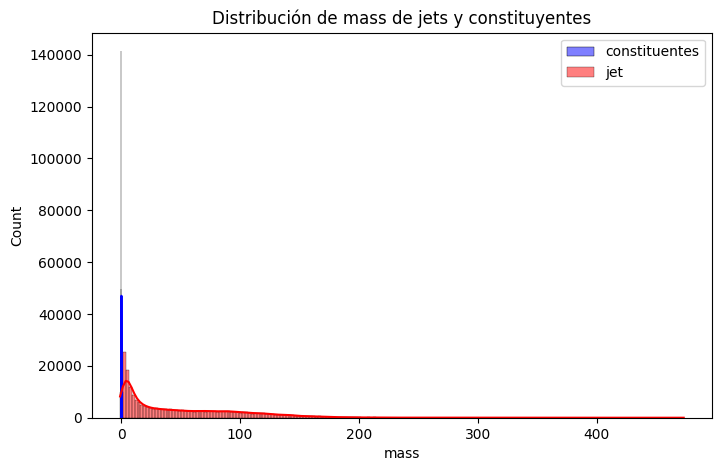

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cand_mass'], color='blue', label='constituentes', kde=True)
sns.histplot(df['jet_mass'], color='red', label='jet', kde=True)
plt.xlabel('mass')
plt.legend()
plt.title('Distribución de mass de jets y constituyentes')
plt.show()

The **standard correlation coefficient**, most commonly Pearson's r, is a statistical measure that quantifies the strength and direction of a linear relationship between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation), with 0 indicating no linear relationship.

In [38]:
cormat2 = df.corr()
round(cormat2,2)

,jet_pt,jet_eta,jet_phi,jet_mass,jet_energy,cand_pt,cand_eta,cand_phi,cand_mass,cand_energy,cand_d0,cand_dz,cand_idx
jet_pt,1.00,0.00,-0.00,0.10,0.31,0.22,0.00,-0.01,0.01,0.13,-0.00,-0.00,0.00
jet_eta,0.00,1.00,-0.01,0.01,-0.00,-0.00,0.99,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00
jet_phi,-0.00,-0.01,1.00,-0.01,0.01,0.00,-0.01,0.92,-0.00,0.00,-0.00,-0.00,0.00
jet_mass,0.10,0.01,-0.01,1.00,-0.03,-0.06,0.01,-0.00,-0.02,-0.08,-0.00,-0.01,0.00
jet_energy,0.31,-0.00,0.01,-0.03,1.00,0.07,-0.00,0.01,0.03,0.38,0.00,0.00,-0.00
cand_pt,0.22,-0.00,0.00,-0.06,0.07,1.00,-0.00,0.00,-0.09,0.80,-0.10,-0.16,-0.63
cand_eta,0.00,0.99,-0.01,0.01,-0.00,-0.00,1.00,-0.01,-0.00,-0.00,-0.00,-0.00,-0.00
cand_phi,-0.01,-0.01,0.92,-0.00,0.01,0.00,-0.01,1.00,-0.01,0.00,-0.00,-0.00,0.00
cand_mass,0.01,-0.00,-0.00,-0.02,0.03,-0.09,-0.00,-0.01,1.00,-0.05,0.63,0.96,0.05
cand_energy,0.13,-0.00,0.00,-0.08,0.38,0.80,-0.00,0.00,-0.05,1.00,-0.08,-0.13,-0.50


<Axes: >

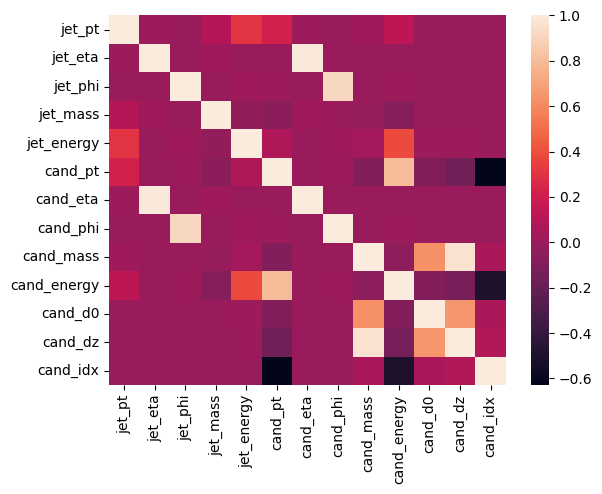

In [39]:
sns.heatmap(cormat2)

# **Now we are going to work with the same data but with a flatted disttributions in $p_T$**


### **Simulated CMS data**

In [ ]:
def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract information from the jet
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        
        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        
        # Calculate pt, eta, phi for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        theta = np.arccos(part_pz / (p_total + 1e-8))  # Avoid division by zero
        eta = -np.log(np.tan(theta / 2 + 1e-8))
        phi = np.arctan2(part_py, part_px)
        
        # Select the num_constituents with the highest pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'energy': part_energy[idx],
                'charge': evento['part_charge'][idx] if 'part_charge' in evento else 0
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'constituents': top_constituents
        })

    return eventos

datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120_flat.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120_flat.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120_flat.json', num_jets=10000, num_constituents=10)
datos_QCD_simu_1 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_2 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_full = datos_QCD_simu_1 + datos_QCD_simu_2

# Jet transverse momentum ($p_T$) distributions

This code plots histograms of the transverse momentum (`jet_pt`) for jets from different datasets: QCD, TTBar, WToqq, and HToBB. Each dataset is plotted separately with 50 bins and no kernel density estimate (KDE), showing the frequency (number of jets) versus `jet_pt`. Grid lines and tight layout improve readability, and each plot has a title indicating the corresponding dataset.


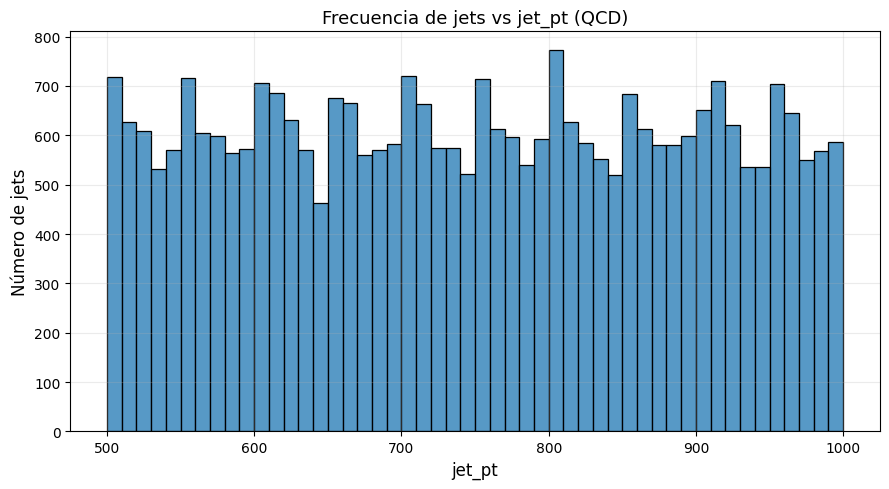

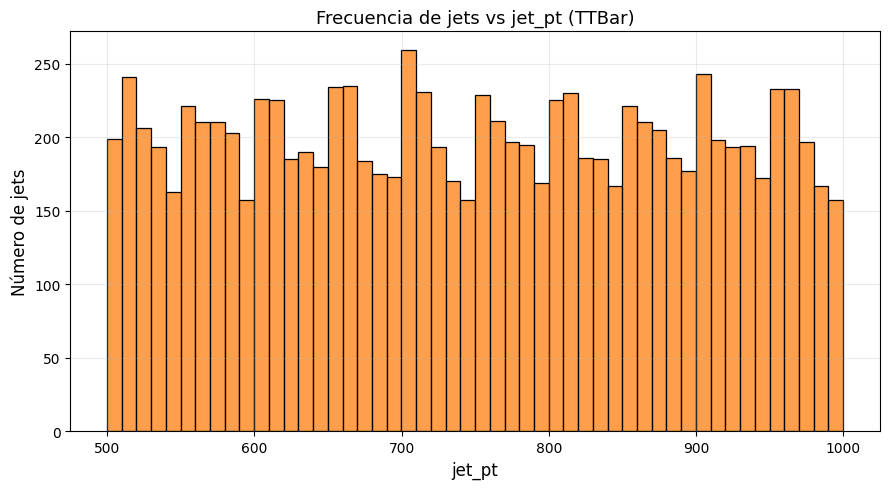

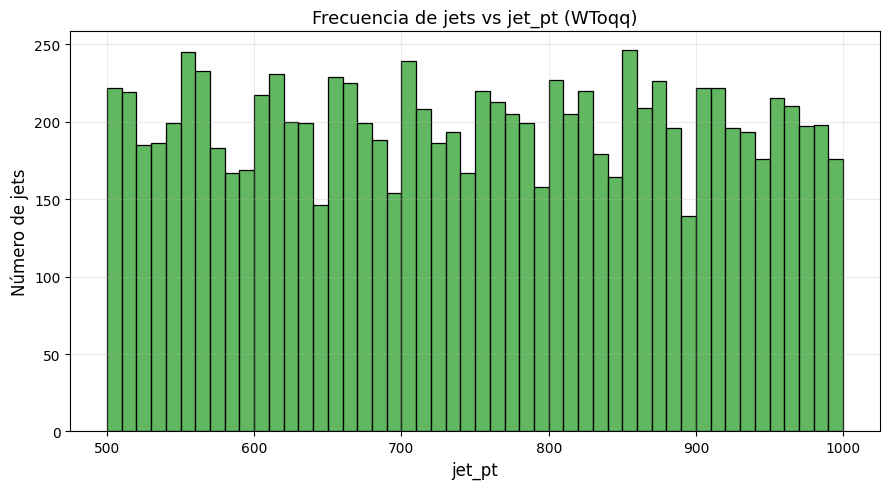

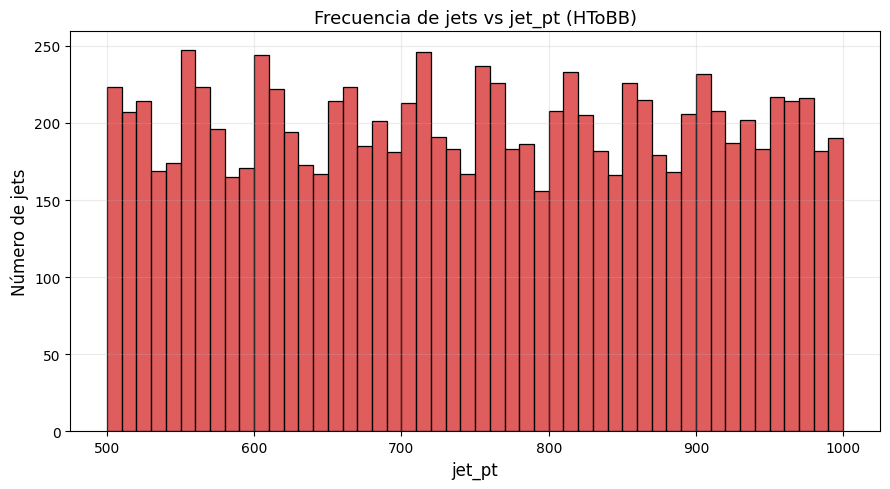

In [ ]:
jet_pts_qcd = [ev['pt_jet'] for ev in datos_QCD_simu_full]
jet_pts_ttbar = [ev['pt_jet'] for ev in datos_TTBar]
jet_pts_wtoqq = [ev['pt_jet'] for ev in datos_WToqq]
jet_pts_htobb = [ev['pt_jet'] for ev in datos_HToBB]


plt.figure(figsize=(9,5))
sns.histplot(jet_pts_qcd, bins=50, color='C0', kde=False)  
plt.xlabel('jet_pt', fontsize=12)
plt.ylabel('Número de jets', fontsize=12)
plt.title('Frecuencia de jets vs jet_pt (QCD)', fontsize=13)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
sns.histplot(jet_pts_ttbar, bins=50, color='C1', kde=False)  
plt.xlabel('jet_pt', fontsize=12)
plt.ylabel('Número de jets', fontsize=12)
plt.title('Frecuencia de jets vs jet_pt (TTBar)', fontsize=13)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
sns.histplot(jet_pts_wtoqq, bins=50, color='C2', kde=False)   
plt.xlabel('jet_pt', fontsize=12)
plt.ylabel('Número de jets', fontsize=12)
plt.title('Frecuencia de jets vs jet_pt (WToqq)', fontsize=13)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,5))
sns.histplot(jet_pts_htobb, bins=50, color='C3', kde=False)   
plt.xlabel('jet_pt', fontsize=12)
plt.ylabel('Número de jets', fontsize=12)
plt.title('Frecuencia de jets vs jet_pt (HToBB)', fontsize=13)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


### **Real CMS data**

In [ ]:
datos = []

def cargar_datos_json(json_path, num_jets=22500, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        jet_pt, jet_eta, jet_phi, jet_mass = evento['jet_kinematics']
        constituents = evento['PFCands']
        theta = 2 * np.arctan(np.exp(-jet_eta))
        p = jet_pt / np.sin(theta)
        pz  = p * np.cos(theta)
        jet_energy = np.sqrt(pz**2 + jet_pt**2 + jet_mass**2)
        

        # Calculate pT for each constituent
        constituents = np.array(constituents)
        px = constituents[:, 0]
        py = constituents[:, 1]
        pt = np.sqrt(px**2 + py**2)

        # Indexes of the top num_constituents by pT
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        top_cands = constituents[indices_ordenados]

        # Convert each to the format used in the circuit
        top_constituents = []
        for cand in top_cands:
            px, py, pz, E = cand[0:4]
            d0 = cand[4]  # traversal impact parameter
            dz = cand[5]  # longitudinal impact parameter
            pt = np.sqrt(px**2 + py**2)
            p_total = np.sqrt(px**2 + py**2 + pz**2)
            eta = 0.5 * np.log((p_total + pz) / (p_total - pz + 1e-8))  # Avoiding dividing by 0
            phi = np.arctan2(py, px)
            mass = np.sqrt(np.maximum(0, E**2 - (px**2 + py**2 + pz**2)))# In case of negative mass, set it to zero
            top_constituents.append({
                'pt': pt,
                'eta': eta,
                'phi': phi,
                'mass': mass,
                'energy': E,
                'd0': d0,
                'dz': dz
            })

        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'constituents': top_constituents
        })

    return eventos



datos_00 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch0_flatpt.json')
datos_01 = cargar_datos_json('/Volumes/usb_MCarou/runG_batch10_flatpt.json')
datos = datos_00 + datos_01

### **Simulated CMS data**

In [ ]:
def cargar_datos_json(json_path, num_jets=10000, num_constituents=10):
    with open(json_path, 'r') as f:
        data = json.load(f)

    eventos = []
    for i, evento in enumerate(data[:num_jets]):
        # Extract jet kinematics
        jet_pt = evento.get('jet_pt', i)
        jet_eta = evento.get('jet_eta', i)
        jet_phi = evento.get('jet_phi', i)
        jet_mass = evento.get('jet_sdmass', i)
        jet_energy = evento.get('jet_energy', i)
        jet_tau1 = evento.get('jet_tau1', i)
        jet_tau2 = evento.get('jet_tau2', i)
        jet_tau3 = evento.get('jet_tau3', i)    
        jet_tau4 = evento.get('jet_tau4', i)

        jet_tau12 = jet_tau2 / jet_tau1 if jet_tau1 != 0 else 0
        jet_tau23 = jet_tau3 / jet_tau2 if jet_tau2 != 0 else 0
        jet_tau34 = jet_tau4 / jet_tau3 if jet_tau3 != 0 else 0

        # Extract constituents (particles)
        part_px = np.array(evento.get('part_px', []))
        part_py = np.array(evento.get('part_py', []))
        part_pz = np.array(evento.get('part_pz', []))
        part_energy = np.array(evento.get('part_energy', []))
        part_d0val = np.array(evento.get('part_d0val', []))
        part_dzval = np.array(evento.get('part_dzval', []))
        
        # Calculate pT, eta, phi, mass for each constituent
        pt = np.sqrt(part_px**2 + part_py**2)
        p_total = np.sqrt(part_px**2 + part_py**2 + part_pz**2)
        eta = 0.5 * np.log((p_total + part_pz) / (p_total - part_pz + 1e-8))  # Avoiding dividing by 0
        phi = np.arctan2(part_py, part_px)
        mass = np.sqrt(np.maximum(0, part_energy**2 - (part_px**2 + part_py**2 + part_pz**2)))
        
        # Select the num_constituents with the highest pt
        indices_ordenados = np.argsort(pt)[::-1][:num_constituents]
        
        top_constituents = []
        for idx in indices_ordenados:
            top_constituents.append({
                'pt': pt[idx],
                'eta': eta[idx],
                'phi': phi[idx],
                'px': part_px[idx],
                'py': part_py[idx],
                'pz': part_pz[idx],
                'mass': mass[idx],
                'energy': part_energy[idx],
                'd0': part_d0val[idx],
                'dz': part_dzval[idx]
            })
            
        eventos.append({
            'pt_jet': jet_pt,
            'eta_jet': jet_eta,
            'phi_jet': jet_phi,
            'mass_jet': jet_mass,
            'energy_jet': jet_energy,
            'tau1_jet': jet_tau1,
            'tau2_jet': jet_tau2,
            'tau3_jet': jet_tau3,
            'tau4_jet': jet_tau4,
            'tau12_jet': jet_tau12,
            'tau23_jet': jet_tau23,
            'tau34_jet': jet_tau34,
            'constituents': top_constituents
        })

    return eventos

datos_HToBB = cargar_datos_json('/Volumes/usb_MCarou/HToBB_120_flat.json', num_jets=10000, num_constituents=10)
datos_TTBar = cargar_datos_json('/Volumes/usb_MCarou/TTBar_120_flat.json', num_jets=10000, num_constituents=10)
datos_WToqq = cargar_datos_json('/Volumes/usb_MCarou/WToQQ_120_flat.json', num_jets=10000, num_constituents=10)
datos_QCD_simu_1 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_2 = cargar_datos_json('/Volumes/usb_MCarou/ZJetsToNuNu_120_flat.json', num_jets=22500, num_constituents=10)
datos_QCD_simu_full = datos_QCD_simu_1 + datos_QCD_simu_2

# Jet τ variable distributions by class

This code creates histograms of jet substructure variables ($\tau_1$, $\tau_2$, $\tau_3$, $\tau_4$, and their ratios $\tau_{12}$, $\tau_{23}$, $\tau_{34}$) for different physics processes: QCD, H→bb, t→bqq, and W→qq. Each dataset is labeled with scientific notation for clarity. Histograms are normalized to density, use log scale for the y-axis, and are colored according to class. This allows comparison of the τ variable distributions across jet types and processes.


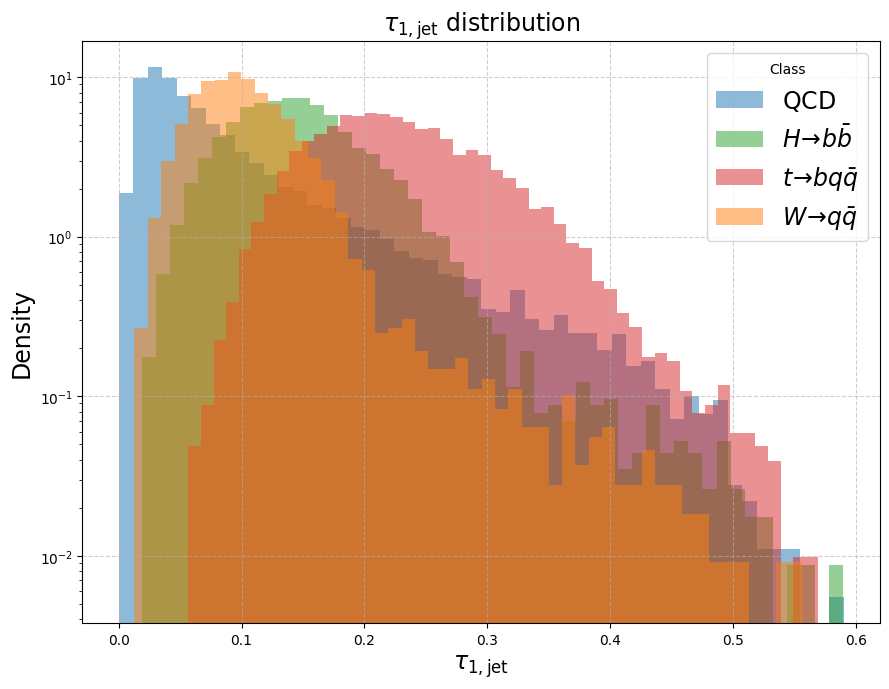

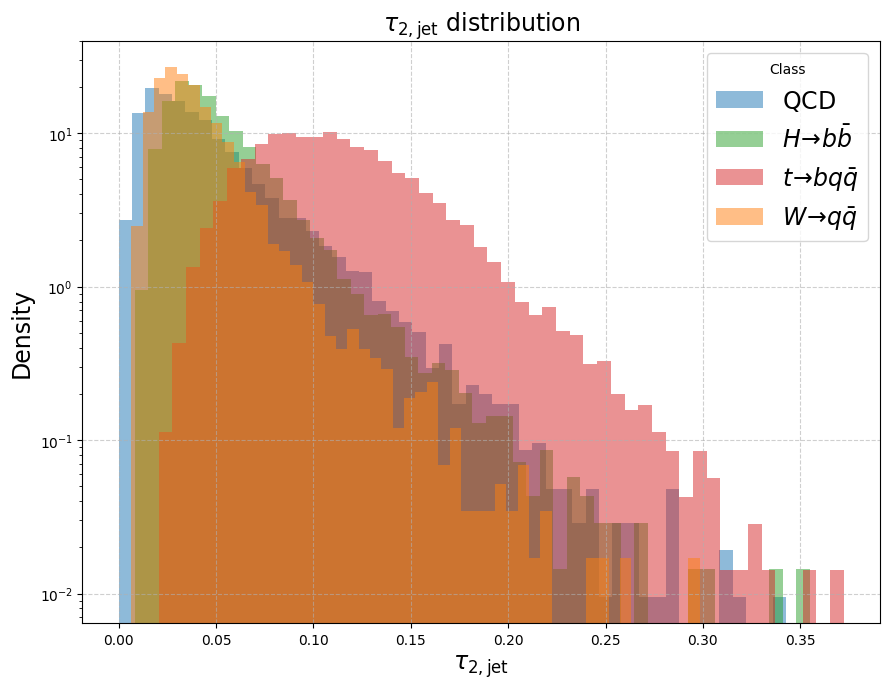

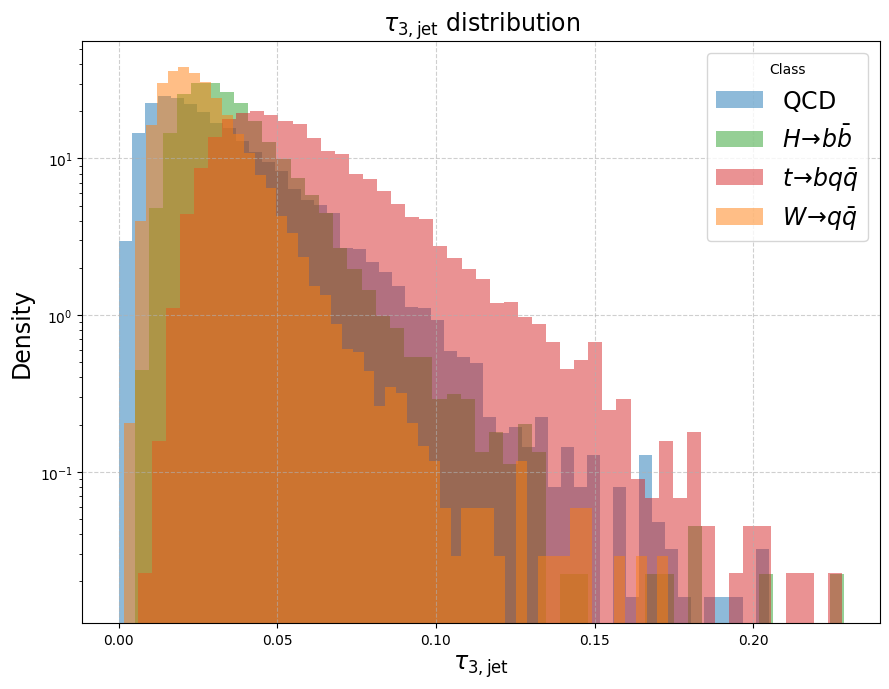

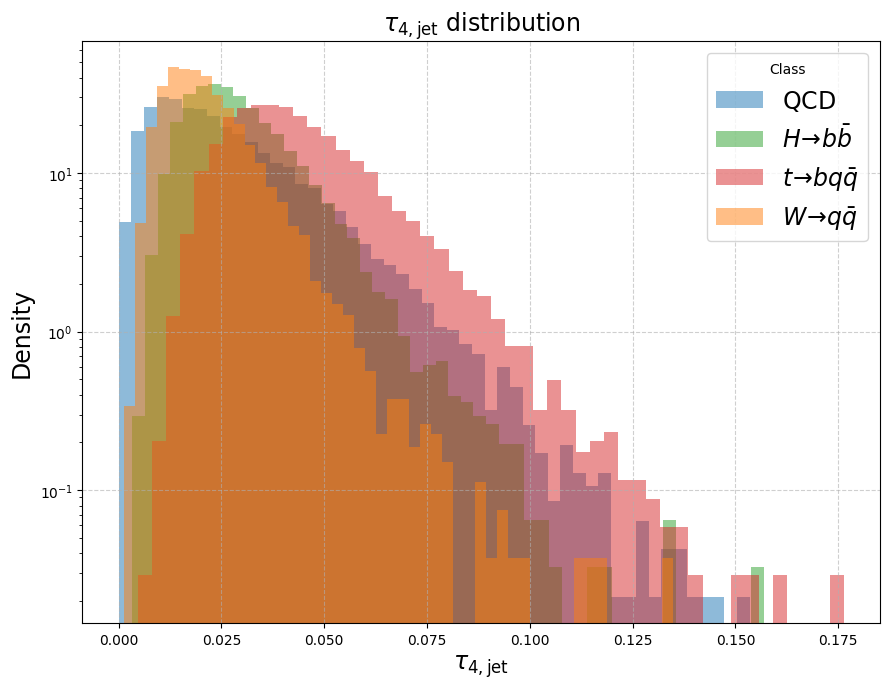

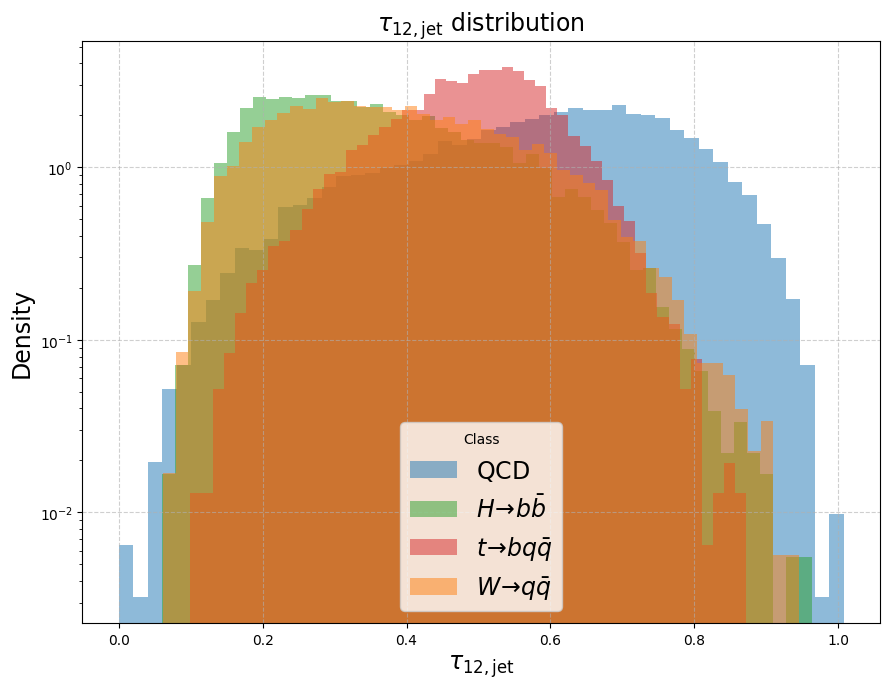

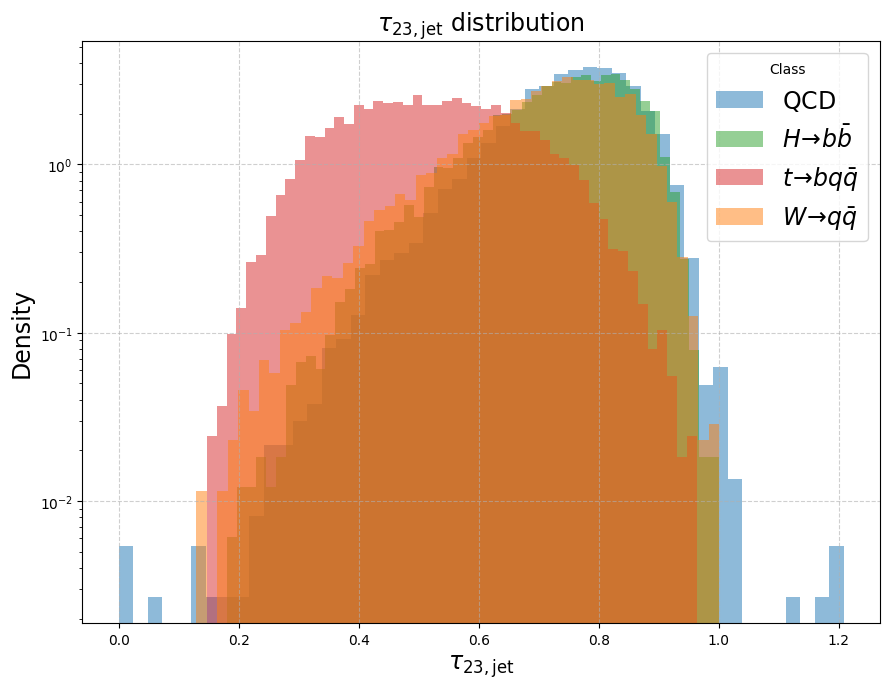

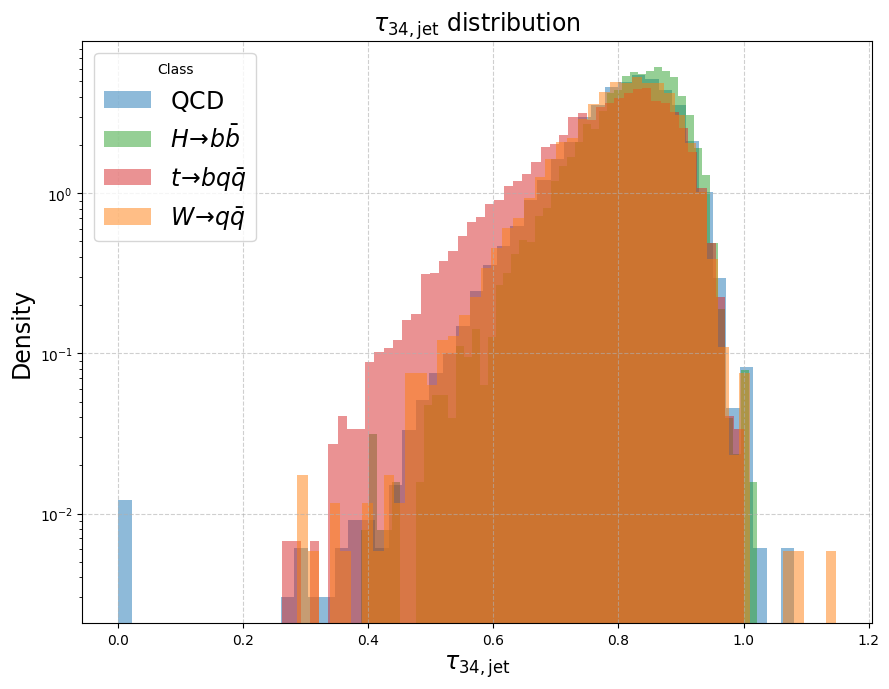

In [ ]:
# Enable LaTeX-style rendering (mathtext)
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "dejavusans"

# --- Mapping classes to scientific notation ---
class_labels = {
    'QCD'   : r"$\mathrm{QCD}$",
    'Hbb'   : r"$H\!\rightarrow\! b\bar{b}$",
    'TT'    : r"$t\!\rightarrow\! bq\bar{q}$",
    'Wqq'   : r"$W\!\rightarrow\! q\bar{q}$"
}

# Create DataFrames with class labels in scientific notation
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_=class_labels['QCD'])
df_Hbb = pd.DataFrame(datos_HToBB).assign(class_=class_labels['Hbb'])
df_TT  = pd.DataFrame(datos_TTBar).assign(class_=class_labels['TT'])
df_Wqq = pd.DataFrame(datos_WToqq).assign(class_=class_labels['Wqq'])

# Combine into a single DataFrame
df_total = pd.concat([df_QCD, df_Hbb, df_TT, df_Wqq], ignore_index=True)

# --- Mapping τ variables ---
taus = {
    "tau1_jet":  r"$\tau_{1,\mathrm{jet}}$",
    "tau2_jet":  r"$\tau_{2,\mathrm{jet}}$",
    "tau3_jet":  r"$\tau_{3,\mathrm{jet}}$",
    "tau4_jet":  r"$\tau_{4,\mathrm{jet}}$",
    "tau12_jet": r"$\tau_{12,\mathrm{jet}}$",
    "tau23_jet": r"$\tau_{23,\mathrm{jet}}$",
    "tau34_jet": r"$\tau_{34,\mathrm{jet}}$",
}

# Optional colors
colors = {
    class_labels['QCD']: 'tab:blue',
    class_labels['Hbb']: 'tab:green',
    class_labels['TT'] : 'tab:red',
    class_labels['Wqq']: 'tab:orange'
}

# --- Plotting ---
for var, label in taus.items():
    plt.figure(figsize=(9,7))
    
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=50, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)

    plt.xlabel(label, fontsize=17)
    plt.ylabel("Density", fontsize=17)
    plt.title(f"{label} distribution", fontsize=17)
    plt.legend(title=r"Class", fontsize=17)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



# Comparison of jet kinematic distributions: QCD vs Real Data

This code compares the distributions of jet kinematic variables (`pt_jet`, `eta_jet`, `phi_jet`, `mass_jet`, `energy_jet`) between simulated QCD events and real experimental data. Data from each class is labeled accordingly, combined into a single DataFrame, and plotted as normalized histograms. Logarithmic scale is used on the y-axis, and colors distinguish the classes, allowing a clear visual comparison of the distributions.


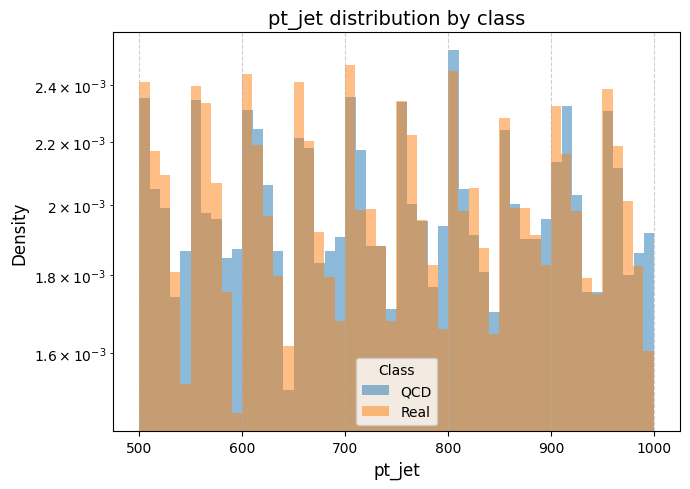

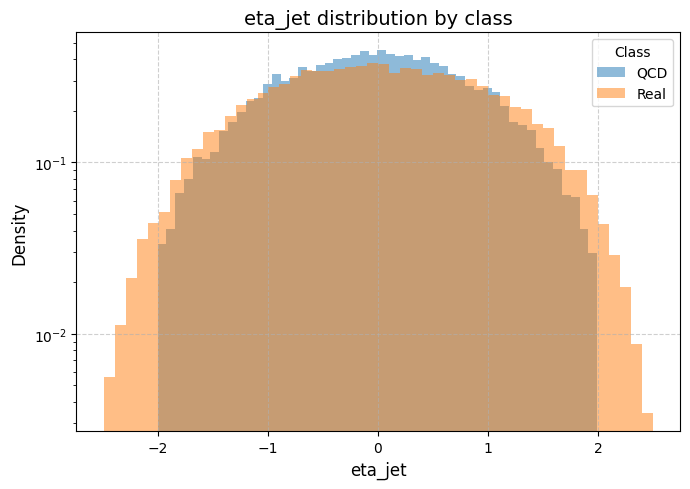

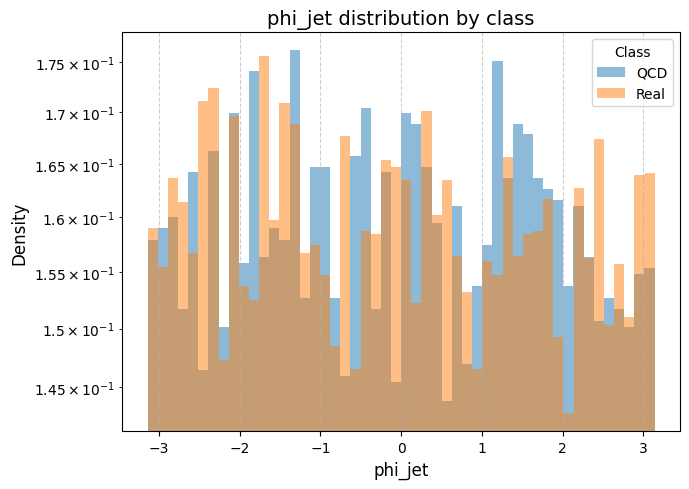

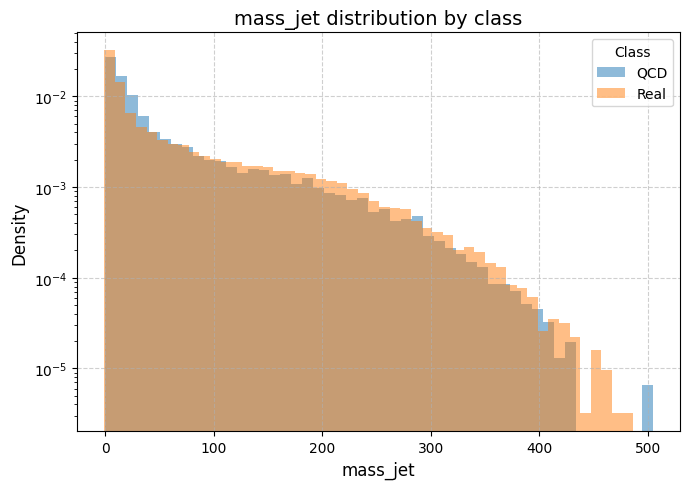

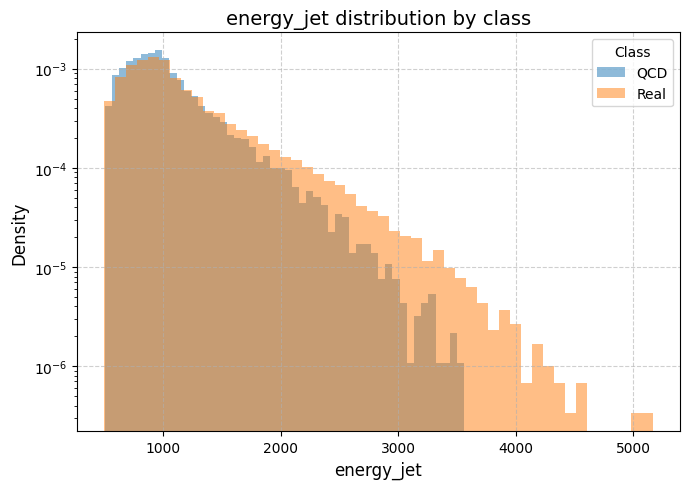

In [ ]:
# Create DataFrames with class labels
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='QCD')
df_real = pd.DataFrame(datos).assign(class_='Real')

# Combine into a single DataFrame
df_total = pd.concat([df_QCD, df_real], ignore_index=True)

# Variables tau to analyze
vars = ["pt_jet", "eta_jet", "phi_jet", "mass_jet", "energy_jet"]

# Optional colors
colors = {'QCD': 'tab:blue', 'Real': 'tab:orange'}

# Plot distributions
for var in vars:
    plt.figure(figsize=(7,5))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=50, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel(var, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"$p_T$ distribution by class", fontsize=14)
    plt.legend(title="Class")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



This code compares the jet transverse momentum ($p_T$) distributions between simulated background jets (`JetClass`, q/g) and real CMS data (`JetHT`, 2016). Each dataset is labeled, combined into a single DataFrame, and plotted as a normalized histogram using a logarithmic y-axis. Colors differentiate the datasets, providing a clear visual comparison of $p_T$ distributions.


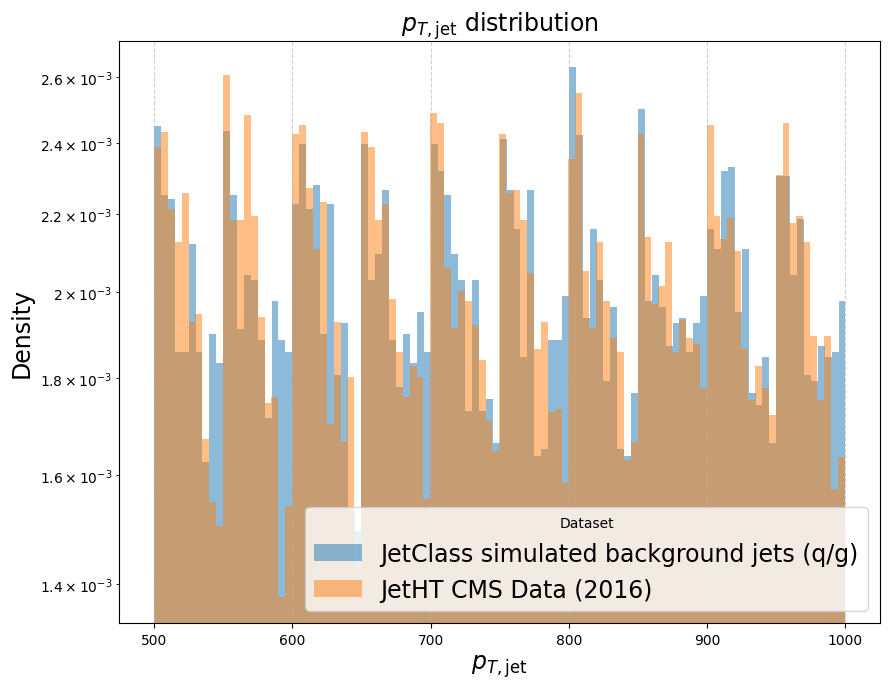

In [ ]:
# Create DataFrames with class labels
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='JetClass simulated background jets (q/g)')
df_real = pd.DataFrame(datos).assign(class_='JetHT CMS Data (2016)')

# Combine into a single DataFrame
df_total = pd.concat([df_QCD, df_real], ignore_index=True)

# Variables tau to analyze
vars = ["pt_jet"]

# Optional colors
colors = {'JetClass simulated background jets (q/g)': 'tab:blue', 'JetHT CMS Data (2016)': 'tab:orange'}

# Plot distributions
for var in vars:
    plt.figure(figsize=(9,7))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=100, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel("$p_{T,\\text{jet}}$", fontsize=17)
    plt.ylabel("Density", fontsize=17)
    plt.title(f"$p_{{T,\\text{{jet}}}}$ distribution", fontsize=17)
    plt.legend(title="Dataset", fontsize=17)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


This code compares the pseudorapidity ($\eta$) distributions of jets between simulated background jets (`JetClass`, q/g) and real CMS data (`JetHT`, 2016). Each dataset is labeled, combined into a single DataFrame, and visualized as normalized histograms with a logarithmic y-axis. Different colors distinguish the datasets, providing a clear comparison of $\eta$ distributions.


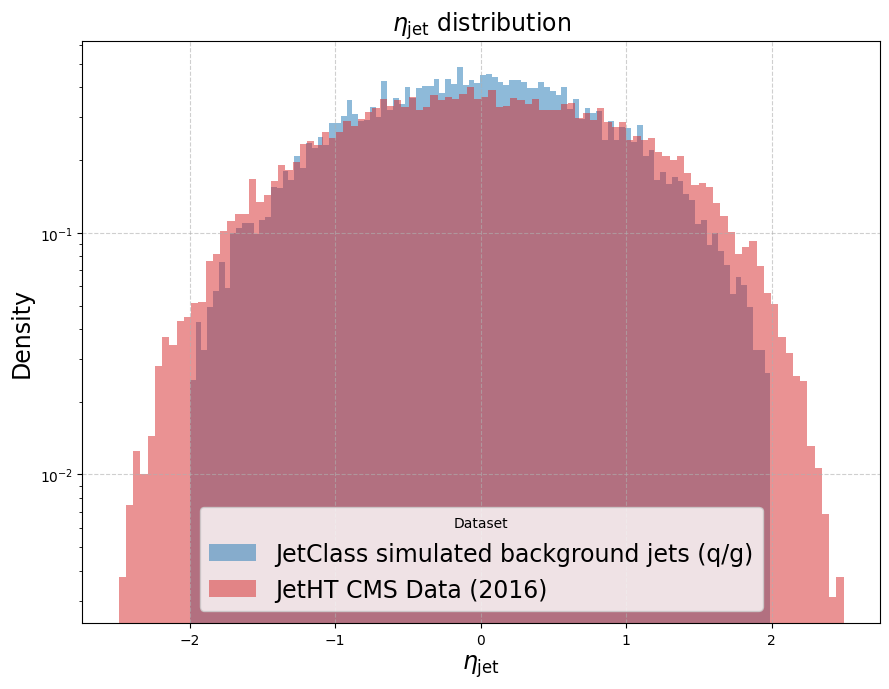

In [ ]:
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='JetClass simulated background jets (q/g)')
df_real = pd.DataFrame(datos).assign(class_='JetHT CMS Data (2016)')
df_total = pd.concat([df_QCD, df_real], ignore_index=True)
vars = ["eta_jet"]
colors = {'JetClass simulated background jets (q/g)': 'tab:blue', 'JetHT CMS Data (2016)': 'tab:red'}

for var in vars:
    plt.figure(figsize=(9,7))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=100, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel("$\\eta_{\\text{jet}}$", fontsize=17)
    plt.ylabel("Density", fontsize=17)
    plt.title(f"$\\eta_{{\\text{{jet}}}}$ distribution", fontsize=17)
    plt.legend(title="Dataset", fontsize=17)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

This code compares the azimuthal angle ($\phi$) distributions of jets between simulated background jets (`JetClass`, q/g) and real CMS data (`JetHT`, 2016). Both datasets are labeled and combined into a single DataFrame. The distributions are visualized as normalized histograms with a logarithmic y-axis, using different colors to distinguish between simulated and real data.

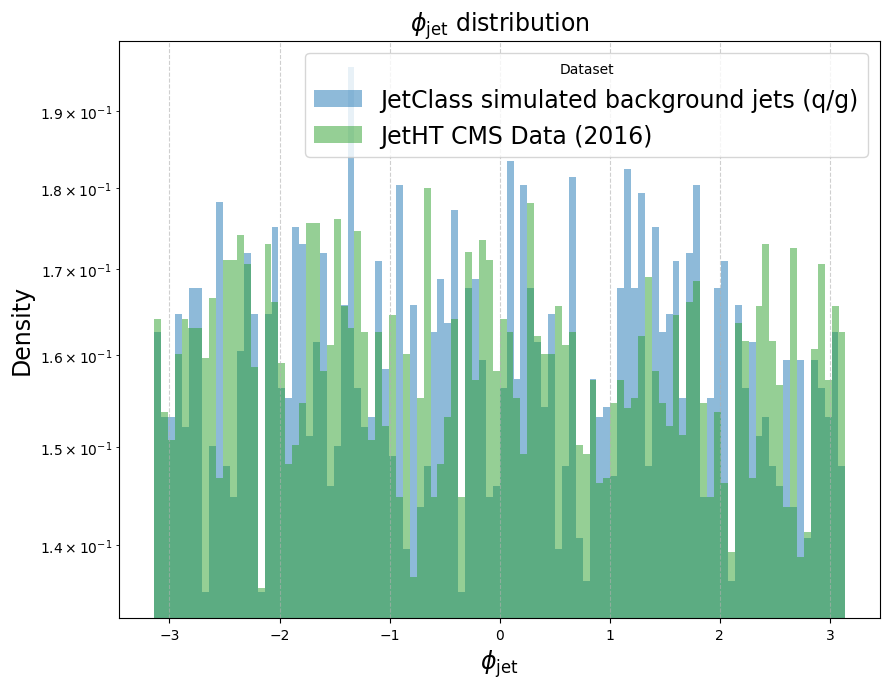

In [ ]:
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='JetClass simulated background jets (q/g)')
df_real = pd.DataFrame(datos).assign(class_='JetHT CMS Data (2016)')
df_total = pd.concat([df_QCD, df_real], ignore_index=True)
vars = ["phi_jet"]
colors = {'JetClass simulated background jets (q/g)': 'tab:blue', 'JetHT CMS Data (2016)': 'tab:green'}


for var in vars:
    plt.figure(figsize=(9,7))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=100, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel("$\\phi_{\\text{jet}}$", fontsize=17)
    plt.ylabel("Density", fontsize=17)
    plt.title(f"$\\phi_{{\\text{{jet}}}}$ distribution", fontsize=17)
    plt.legend(title="Dataset", fontsize=17)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

This code visualizes the jet mass ($m_{\text{jet}}$) distributions for simulated background jets (`JetClass`, q/g) and real CMS data (`JetHT`, 2016). Both datasets are labeled and merged into a single DataFrame. The distributions are displayed as normalized histograms with a logarithmic y-axis, using distinct colors for each dataset to allow direct comparison.

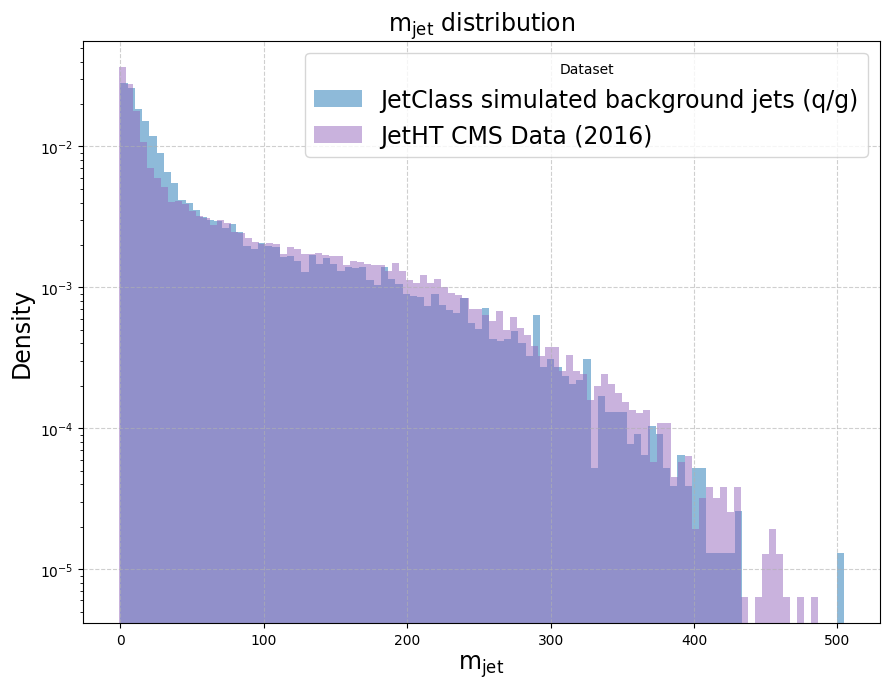

In [ ]:
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='JetClass simulated background jets (q/g)')
df_real = pd.DataFrame(datos).assign(class_='JetHT CMS Data (2016)')
df_total = pd.concat([df_QCD, df_real], ignore_index=True)

vars = ["mass_jet"]
colors = {'JetClass simulated background jets (q/g)': 'tab:blue', 'JetHT CMS Data (2016)': 'tab:purple'}
for var in vars:
    plt.figure(figsize=(9,7))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=100, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel("$\\text{m}_{\\text{jet}}$", fontsize=17)
    plt.ylabel("Density", fontsize=17)
    plt.title(f"$\\text{{m}}_{{\\text{{jet}}}}$ distribution", fontsize=17)
    plt.legend(title="Dataset", fontsize=17)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

This code plots the energy ($E_{\text{jet}}$) distributions for simulated background jets (`JetClass`, q/g) and real CMS data (`JetHT`, 2016). Both datasets are labeled, merged into a single DataFrame, and displayed as normalized histograms with a logarithmic y-axis. Different colors are used to clearly distinguish the datasets for comparison.

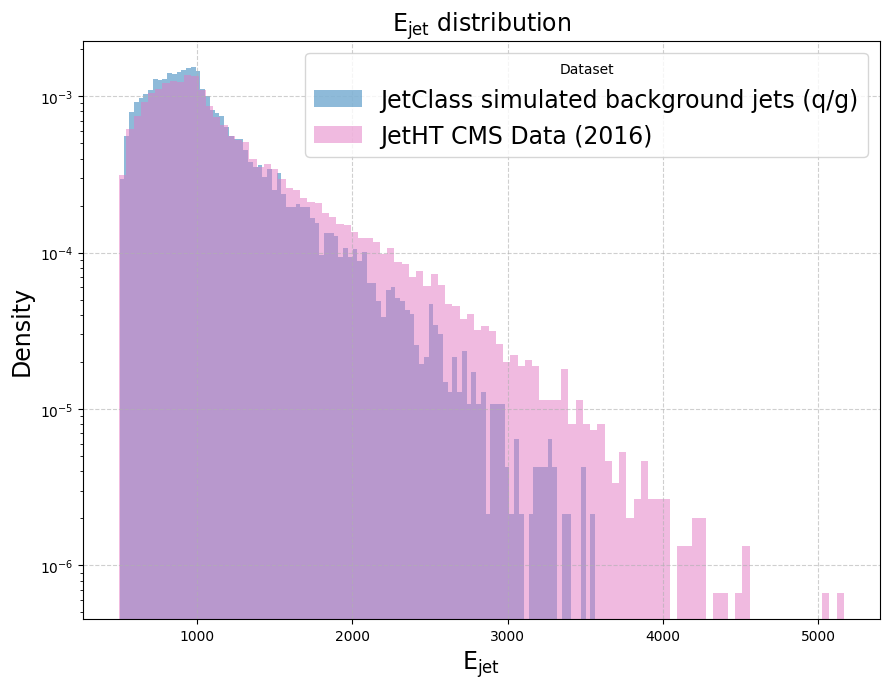

In [ ]:
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='JetClass simulated background jets (q/g)')
df_real = pd.DataFrame(datos).assign(class_='JetHT CMS Data (2016)')
df_total = pd.concat([df_QCD, df_real], ignore_index=True)
vars = ["energy_jet"]
colors = {'JetClass simulated background jets (q/g)': 'tab:blue', 'JetHT CMS Data (2016)': 'tab:pink'}


for var in vars:
    plt.figure(figsize=(9,7))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=100, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel("$\\text{E}_{\\text{jet}}$", fontsize=17)
    plt.ylabel("Density", fontsize=17)
    plt.title(f"$\\text{{E}}_{{\\text{{jet}}}}$ distribution", fontsize=17)
    plt.legend(title="Dataset", fontsize=17)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

In [ ]:
df_QCD = pd.DataFrame(datos_QCD_simu_full).assign(class_='QCD')
df_Hbb = pd.DataFrame(datos_HToBB).assign(class_='H→bb')
df_TT  = pd.DataFrame(datos_TTBar).assign(class_='t→bqq')
df_Wqq = pd.DataFrame(datos_WToqq).assign(class_='W→qq')

# Unirlos en un único DataFrame
df_total = pd.concat([df_QCD, df_Hbb, df_TT, df_Wqq], ignore_index=True)

# Variables tau a analizar
taus = ["tau1_jet", "tau2_jet", "tau3_jet", "tau4_jet",
        "tau12_jet", "tau23_jet", "tau34_jet"]

# Colores opcionales
colors = {'QCD': 'tab:blue', 'H→bb': 'tab:green', 't→bqq': 'tab:red', 'W→qq': 'tab:orange'}

# Graficar distribuciones
for var in taus:
    plt.figure(figsize=(7,5))
    for cls in df_total["class_"].unique():
        subset = df_total[df_total["class_"] == cls]
        plt.hist(subset[var], bins=50, density=True, alpha=0.5,
                 label=cls, color=colors.get(cls, None),
                 histtype='stepfilled', linewidth=1.5, log=True)
    plt.xlabel(var, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"{var} distribution by class", fontsize=14)
    plt.legend(title="Class")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
